In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
Vegas = pd.read_csv('vegas.csv')
Vegas.columns = Vegas.columns.str.replace('\.*\s+', '_').str.lower()

In [3]:
Vegas.shape

(504, 20)

In [4]:
Vegas.head()

,user_country,nr_reviews,nr_hotel_reviews,helpful_votes,score,period_of_stay,traveler_type,pool,gym,tennis_court,spa,casino,free_internet,hotel_name,hotel_stars,nr_rooms,user_continent,member_years,review_month,review_weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


# General Split-Apply-Combine

Remember the basic workflow of split-apply-combine.

<img src="s-a-c.png">

So far, we've looked at aggregation, which is one example of a split-apply-combine procedure. Aggregation is limited in some ways.  Each group is reduced to a single row of information.  Columns are processed independently, so one variable can't affect the way another is aggregated.

For more general split-apply-combine operations, Pandas gives us the `apply()` method.  With this method, we can perform arbitrary processing on each group, turning into a `Series` or `DataFrame` with any shape.  Whatever the results look like, Pandas will try to concatenate them together vertically.

### Example 1.

Let's see a simple example.  Suppose we want information about the 3 reviewers for each hotel who have the most review-writing experience. Notice that this is not an aggregation, because the result from each group will span three rows.

To begin with, let's group by `hotel_name` and pull out one group we can experiment with.

In [5]:
by_hotel = Vegas.groupby('hotel_name')

In [6]:
# By_hotel is a groupby object
for k, v in by_hotel:
    print("key: ", k)
    print(by_hotel.get_group(k), "\n\n")

key:  Bellagio Las Vegas
    user_country  nr_reviews  nr_hotel_reviews  helpful_votes  score  \
432    Australia          16                 6              3      4   
433          USA          15                 3             13      5   
434          USA          30                 6             26      4   
435          USA          41                 9            111      5   
436        India          44                35             53      5   
437          USA          30                 9             17      2   
438      Ireland          23                10             18      5   
439        Spain           3                 0              8      2   
440           UK          12                 6             16      3   
441           UK          15                 6             17      5   
442           UK           5                 0              5      5   
443          USA          32                 5             11      4   
444          USA          28           

407             5     December       Saturday   


key:  Wynn Las Vegas
    user_country  nr_reviews  nr_hotel_reviews  helpful_votes  score  \
192          USA         164                48             82      5   
193          USA           5                 3              9      5   
194       Canada           7                 5             20      4   
195          USA          18                11             15      5   
196          USA          20                13             16      5   
197          USA          21                 5             12      4   
198          USA         125                35             48      5   
199          USA          11                 7             10      4   
200    Singapore          16                10             16      3   
201           UK          19                 5              5      5   
202          USA          73                27            365      5   
203          USA           5                 4              4   

In [7]:
Vegas.hotel_name.unique()

array(['Circus Circus Hotel & Casino Las Vegas',
       'Excalibur Hotel & Casino', 'Monte Carlo Resort&Casino',
       'Treasure Island- TI Hotel & Casino',
       'Tropicana Las Vegas - A Double Tree by Hilton Hotel',
       'Caesars Palace', 'The Cosmopolitan Las Vegas',
       'The Palazzo Resort Hotel Casino', 'Wynn Las Vegas',
       'Trump International Hotel Las Vegas', 'The Cromwell',
       'Encore at wynn Las Vegas',
       'Hilton Grand Vacations on the Boulevard',
       "Marriott's Grand Chateau", 'Tuscany Las Vegas Suites & Casino',
       'Hilton Grand Vacations at the Flamingo', 'Wyndham Grand Desert',
       'The Venetian Las Vegas Hotel', 'Bellagio Las Vegas',
       'Paris Las Vegas', 'The Westin las Vegas Hotel Casino & Spa'],
      dtype=object)

In [8]:
sample_group = by_hotel.get_group('Circus Circus Hotel & Casino Las Vegas')

In [9]:
sample_group.head()

,user_country,nr_reviews,nr_hotel_reviews,helpful_votes,score,period_of_stay,traveler_type,pool,gym,tennis_court,spa,casino,free_internet,hotel_name,hotel_stars,nr_rooms,user_continent,member_years,review_month,review_weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


Next, we need to write a function that takes a group like this as input, and returns information about the 3 most experienced reviewers.  We can use `sort_values` followed by `iloc` to pull out the top three rows.  We'll also keep only the first five columns of the result, to simplify the output.

In [10]:
def top_reviewers(group):
    return group.sort_values(by = 'nr_reviews', ascending = False).iloc[:3, :5]

In [11]:
def top_reviewers(group):
    "We can also do this more explicitly by column name instead of positional index"
    return group.sort_values(by = 'nr_reviews', ascending = False).head(3)[['user_country', 'nr_reviews', 'nr_hotel_reviews', 'helpful_votes','score']]

In [12]:
sample_group.head()

,user_country,nr_reviews,nr_hotel_reviews,helpful_votes,score,period_of_stay,traveler_type,pool,gym,tennis_court,spa,casino,free_internet,hotel_name,hotel_stars,nr_rooms,user_continent,member_years,review_month,review_weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday


Once we write our function, the next step is to test it on our sample group, to see if it works properly.

In [13]:
top_reviewers(sample_group)

,user_country,nr_reviews,nr_hotel_reviews,helpful_votes,score
15,New Zeland,146,17,33,4
1,USA,119,21,75,3
10,USA,102,24,58,2


Finally, let's apply the function to all groups, by passing it into `apply`.

In [14]:
by_hotel.apply(top_reviewers)

user_country  nr_reviews  nr_hotel_reviews  \
hotel_name                                                            
Bellagio Las Vegas   447     Scotland         102                25   
                     445        Korea          77                18   
                     449          USA          62                13   
Caesars Palace       121          USA         161                33   
                     122  Puerto Rico         153                38   
...                               ...         ...               ...   
Wyndham Grand Desert 406          USA         289                28   
                     405          USA         182                24   
Wynn Las Vegas       192          USA         164                48   
                     210          USA         142                17   
                     198          USA         125                35   

                          helpful_votes  score  
hotel_name                                      
Bellagio Las Vegas   447             37      5  
                     445             48      4  
                     449             31      4  
Caesars Palace       121             85      4  
                     122             81      5  
...                                 ...    ...  
Wyndham Grand Desert 406            133      4  
                     405             47      4  
Wynn Las Vegas       192             82      5  
                     210             31      4  
                     198             48      5  

[63 rows x 5 columns]

You can see that Pandas applied our function to each group, resulting in a three-row dataframe, then glued these together vertically.  We also get a hierarchical index where level 0 is formed by the group key, so we can tell the chunks apart.

### Example 2.

We previously saw how to aggregate scores into a mean score for each hotel.  To get more detail, we may want to create a table to show the percentage of 5's, the percentage of 4's, and so on.  Imagine putting the hotels on the Y=axis, with a column for each score between 1 and 5.  

Once again, this isn't an aggregation, because a single column of data will turn into 5 columns in the result.  Let's write a custom function and test it on our sample group.

In [15]:
def score_detail(group):
    return group.score.value_counts(normalize = True)

In [16]:
score_detail(sample_group)
# Value count of star reviews

4   0.38
3   0.29
2   0.17
5   0.08
1   0.08
Name: score, dtype: float64

That seems to work, so let's go ahead and apply it to all groups with `apply`.

In [17]:
by_hotel.apply(score_detail)

hotel_name             
Bellagio Las Vegas    5   0.50
                      4   0.33
                      2   0.12
                      3   0.04
Caesars Palace        5   0.50
                          ... 
Wyndham Grand Desert  3   0.12
Wynn Las Vegas        5   0.75
                      4   0.17
                      3   0.04
                      2   0.04
Name: score, Length: 85, dtype: float64

The result is working, but it's not in the format we want.  Instead of a wide table, we get a tall `DataFrame` with a hierarchical index.  To fix this, we could use `unstack()`.

In [18]:
by_hotel.apply(score_detail).unstack()
# Pivot a level of the heirarcical index labels
# Default to remove last level ("Rank" e.g. 1,2,3... at index 1)

,1,2,3,4,5
hotel_name,,,,,
Bellagio Las Vegas,nan,0.12,0.04,0.33,0.50
Caesars Palace,0.08,nan,0.12,0.29,0.50
Circus Circus Hotel & Casino Las Vegas,0.08,0.17,0.29,0.38,0.08
Encore at wynn Las Vegas,0.04,nan,0.04,0.21,0.71
Excalibur Hotel & Casino,nan,0.04,0.38,0.42,0.17
Hilton Grand Vacations at the Flamingo,nan,0.08,0.25,0.29,0.38
Hilton Grand Vacations on the Boulevard,0.04,0.08,0.04,0.33,0.50
Marriott's Grand Chateau,nan,nan,0.04,0.38,0.58
Monte Carlo Resort&Casino,0.04,0.21,0.25,0.42,0.08


Notice that there are some missing values, which should be replaced with zero.  We can fix that with `fillna()`.

In [19]:
by_hotel.apply(score_detail).unstack()

,1,2,3,4,5
hotel_name,,,,,
Bellagio Las Vegas,nan,0.12,0.04,0.33,0.50
Caesars Palace,0.08,nan,0.12,0.29,0.50
Circus Circus Hotel & Casino Las Vegas,0.08,0.17,0.29,0.38,0.08
Encore at wynn Las Vegas,0.04,nan,0.04,0.21,0.71
Excalibur Hotel & Casino,nan,0.04,0.38,0.42,0.17
Hilton Grand Vacations at the Flamingo,nan,0.08,0.25,0.29,0.38
Hilton Grand Vacations on the Boulevard,0.04,0.08,0.04,0.33,0.50
Marriott's Grand Chateau,nan,nan,0.04,0.38,0.58
Monte Carlo Resort&Casino,0.04,0.21,0.25,0.42,0.08


If you don't like `unstack()`, there is another way to put the data into the right shape.  This way takes longer, but I think it's worth seeing to get a deeper understanding of split-apply-combine.  

Our problem was that our custom function returns a `Series`, so it's not clear if the orientation we want is horizontal or vertical.  We could force it to be the way we want by turning the `Series` into a `DataFrame`.  The `.T` is needed to transpose the result into a single row.

In [20]:
def score_detail_2(group):
    return pd.DataFrame(group.score.value_counts(normalize = True)).T

In [21]:
score_detail_2(sample_group)

,4,3,2,5,1
score,0.38,0.29,0.17,0.08,0.08


Notice that the order is wrong here, but Python might fix this for us later.  Let's go ahead and apply to all groups.

In [22]:
by_hotel.apply(score_detail_2)

,,1,2,3,4,5
hotel_name,,,,,,
Bellagio Las Vegas,score,nan,0.12,0.04,0.33,0.50
Caesars Palace,score,0.08,nan,0.12,0.29,0.50
Circus Circus Hotel & Casino Las Vegas,score,0.08,0.17,0.29,0.38,0.08
Encore at wynn Las Vegas,score,0.04,nan,0.04,0.21,0.71
Excalibur Hotel & Casino,score,nan,0.04,0.38,0.42,0.17
Hilton Grand Vacations at the Flamingo,score,nan,0.08,0.25,0.29,0.38
Hilton Grand Vacations on the Boulevard,score,0.04,0.08,0.04,0.33,0.50
Marriott's Grand Chateau,score,nan,nan,0.04,0.38,0.58
Monte Carlo Resort&Casino,score,0.04,0.21,0.25,0.42,0.08


Notice that we get an extra index at level 1, which we don't want.  We can get rid of this with a call to `reset_index`.  We'll also fill in the missing values at this point.

In [23]:
score_df = by_hotel.apply(score_detail_2).reset_index(level=1, drop = True).fillna(0)
score_df

,1,2,3,4,5
hotel_name,,,,,
Bellagio Las Vegas,0.00,0.12,0.04,0.33,0.50
Caesars Palace,0.08,0.00,0.12,0.29,0.50
Circus Circus Hotel & Casino Las Vegas,0.08,0.17,0.29,0.38,0.08
Encore at wynn Las Vegas,0.04,0.00,0.04,0.21,0.71
Excalibur Hotel & Casino,0.00,0.04,0.38,0.42,0.17
Hilton Grand Vacations at the Flamingo,0.00,0.08,0.25,0.29,0.38
Hilton Grand Vacations on the Boulevard,0.04,0.08,0.04,0.33,0.50
Marriott's Grand Chateau,0.00,0.00,0.04,0.38,0.58
Monte Carlo Resort&Casino,0.04,0.21,0.25,0.42,0.08


Let's try turning this into a heatmap.

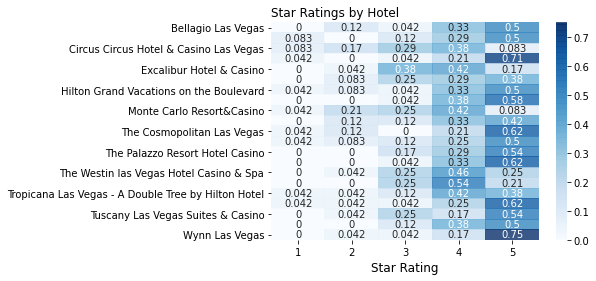

In [24]:
import seaborn as sns
ax = sns.heatmap(score_df, annot=True, cmap = 'Blues', alpha = .8)
ax.set_xlabel('Star Rating', fontsize=12)
ax.set_ylabel('', fontsize=12)
ax.set_title('Star Ratings by Hotel', fontsize=12, loc='left')
plt.show()

### Example 3

Suppose you want to know where the reviewers for each hotel are coming from.  You imagine a table where the hotels are on the y-axis, and each column shows the fraction of a hotel's reviewers that come from a given country.  To keep things compact, you want to include only the 10 most common countries.  The final table might begin like this.

  | USA | Cananda | Australia | ...
---|---|---|---|---
Circus Circus |  .53 | .33 | .12 |...
Ballagio | .44 | .35 | .09 | ...

Statistically speaking, this won't be a very meaningful exercise:  We have a very small sample of reviewers, and they may have been selected using a complex procedure, which means that they're not representative of customers as a whole.  Still, it's a great way to show off the power of `groupby`.  

When you have a challenge like this, you have to think backwards.  How can you create each of these rows so that Pandas can paste them together into the final table?

Let's start writing a function to pass into `apply`.  We know that `value_counts()` gives us close to what we want.

In [25]:
def country_counts(group):
    return group.user_country.value_counts()

In [26]:
country_counts(sample_group)

USA           10
Canada         5
UK             5
New Zeland     2
Australia      1
India          1
Name: user_country, dtype: int64

If we pass this function into `apply`, we get some good information, but it's in the wrong shape and the countries for each hotel don't match.

In [27]:
by_hotel.apply(country_counts)

hotel_name                    
Bellagio Las Vegas  USA           8
                    UK            6
                    Ireland       2
                    India         2
                    Australia     1
                                 ..
Wynn Las Vegas      Canada        5
                    UK            4
                    Costa Rica    1
                    Finland       1
                    Singapore     1
Name: user_country, Length: 182, dtype: int64

We know that we only want to keep the top 10 countries in our final table.  Let's pull those out first.

In [28]:
top_countries = Vegas.user_country.value_counts().index.values[0:10]
top_countries

array(['USA', 'UK', 'Canada', 'Australia', 'Ireland', 'India', 'Mexico',
       'Germany', 'Egypt', 'New Zeland'], dtype=object)

When we call `value_counts`, we get a `Series` indexed by country, and we need to only keep the countries on this list.  We can do that by bracket indexing with `top_countries`.  We also need to use `fillna()` to account for missing values.

In [29]:
def country_counts_2(group):
    return group.user_country.value_counts(normalize = True)[top_countries].fillna(0)

In [30]:
country_counts_2(sample_group)

USA          0.42
UK           0.21
Canada       0.21
Australia    0.04
Ireland      0.00
India        0.04
Mexico       0.00
Germany      0.00
Egypt        0.00
New Zeland   0.08
Name: user_country, dtype: float64

That seems to work on our sample group, so we can go head and apply to all groups.

In [31]:
by_hotel.apply(country_counts_2)

user_country,USA,UK,Canada,Australia,Ireland,India,Mexico,Germany,Egypt,New Zeland
hotel_name,,,,,,,,,,
Bellagio Las Vegas,0.33,0.25,0.04,0.04,0.08,0.08,0.00,0.00,0.00,0.00
Caesars Palace,0.58,0.17,0.12,0.08,0.00,0.00,0.00,0.00,0.00,0.00
Circus Circus Hotel & Casino Las Vegas,0.42,0.21,0.21,0.04,0.00,0.04,0.00,0.00,0.00,0.08
Encore at wynn Las Vegas,0.58,0.29,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00
Excalibur Hotel & Casino,0.25,0.12,0.17,0.08,0.12,0.00,0.00,0.00,0.04,0.00
Hilton Grand Vacations at the Flamingo,0.50,0.04,0.17,0.08,0.00,0.04,0.04,0.00,0.00,0.00
Hilton Grand Vacations on the Boulevard,0.42,0.17,0.12,0.08,0.00,0.00,0.08,0.00,0.00,0.00
Marriott's Grand Chateau,0.33,0.04,0.12,0.08,0.00,0.00,0.04,0.08,0.00,0.00
Monte Carlo Resort&Casino,0.25,0.17,0.08,0.04,0.08,0.00,0.04,0.00,0.00,0.04


Let's throw this into a heatmap to look for any prominent features.

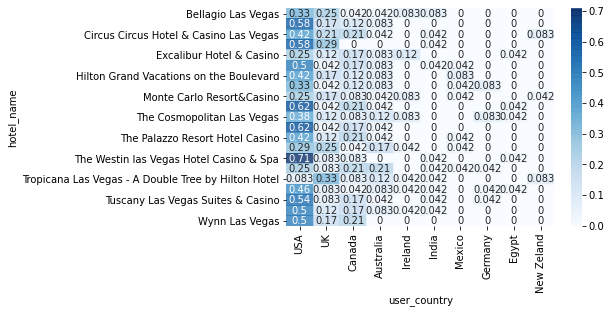

In [32]:
sns.heatmap(by_hotel.apply(country_counts_2), annot = True, cmap = 'Blues', alpha = .8)

Since we have such a small sample, the features we see here are very likely to be noise.  Still, if you imagine that this were a larger and representative sample of hotel customers, you could start to pick out interesting facts - which hotels attract an international crowd and so forth.

Group operations can get a lot more complicated than this, and they often require creativity to pull off.  There are some more good examples of using `apply` in the textbook - I highly recommend you take a look at those.

Finally remember two simple tips.

1. get a sample group to experiment on.
2. work backwards: draw out what you want your final table to look like.  Inspect a single row and figure out how to create it from a group.  (Note: it could be a set of rows, or a column or a set of columns.

## Pair Programming

Answer the following questions

1. How do travel patterns differ by traveller type? Do business travellers frequent different hotels from friends and solo travels?

2. Are there trends in hotel reviews improving or or staying consistent across period of stay or review month?

Before you code, Write out (in markdown cell)
* What variables will you group by?
* What function will you apply? 
* What will the resulting shape be of the output? 